<a href="https://colab.research.google.com/github/desve/vk-text-to-image-demo/blob/main/04_service_layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Установка и импорт

In [1]:
!pip install -q diffusers transformers accelerate safetensors

import torch
from diffusers import StableDiffusionXLPipeline
from PIL import Image
import io, os

# 2. Инициализация модели

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

pipe = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16 if device == "cuda" else torch.float32
).to(device)

pipe.enable_attention_slicing()

Device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

text_encoder_2/model.safetensors:   0%|          | 0.00/2.78G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/10.3G [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vae_1_0/diffusion_pytorch_model.safetens(…):   0%|          | 0.00/335M [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


# 3. Базовые стили и промпты

In [8]:
styles = {
    "neutral": "digital illustration, soft lighting",
    "vk_flat": "flat illustration, clean lines, blue and violet colors",
    "neon": "neon cyberpunk style, glowing edges, high contrast",
    "experimental": "3d render, isometric view, minimalistic shapes"
}

main_styles = ["vk_flat", "neon"]

base_prompts = {
    "Самопрезентация": (
        "one young AI engineer on stage with microphone, "
        "big screen behind showing neural network diagram, tech conference"
    ),
    "Профессиональное достижение": (
        "data scientist working late at night in a modern office, "
        "only monitor light and city lights outside window, charts and neural networks on screens"
    ),
    "Команда VK": (
        "three interns in a modern IT office, sitting around a round table with laptops and sticky notes, "
        "warm friendly atmosphere"
    )
}

def build_prompt(base, style_key):
    return f"{base}, {styles[style_key]}"

In [4]:
# Генерация уменьшенного изображения
def generate_one(
    prompt,
    steps=25,
    guidance=7.5,
    seed=None,
    height=512,
    width=512
):
    generator = None
    if seed is not None:
        generator = torch.Generator(device=device).manual_seed(seed)

    image = pipe(
        prompt,
        num_inference_steps=steps,
        guidance_scale=guidance,
        num_images_per_prompt=1,
        generator=generator,
        height=height,
        width=width
    ).images[0]
    return image

In [6]:
# Сжатие и сохранение результата
os.makedirs("outputs_small", exist_ok=True)

def save_compressed(img: Image.Image, filename: str, quality: int = 75):
    """
    Сохраняет картинку как JPEG с сжатием и печатает примерный размер файла.
    """
    path = os.path.join("outputs_small", filename)

    buffer = io.BytesIO()
    img.save(buffer, format="JPEG", quality=quality, optimize=True)
    size_kb = len(buffer.getvalue()) / 1024
    print(f"{filename}: ~{size_kb:.0f} KB")

    img.save(path, format="JPEG", quality=quality, optimize=True)
    return path


===  Самопрезентация  ===
Стиль: vk_flat


  0%|          | 0/25 [00:00<?, ?it/s]

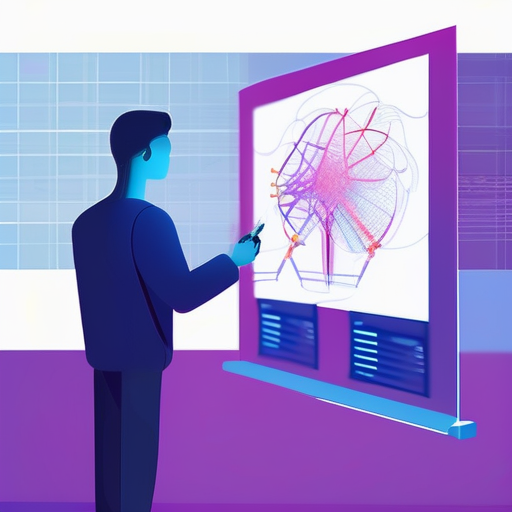

Самопрезентация_vk_flat.jpg: ~24 KB
Стиль: neon


  0%|          | 0/25 [00:00<?, ?it/s]

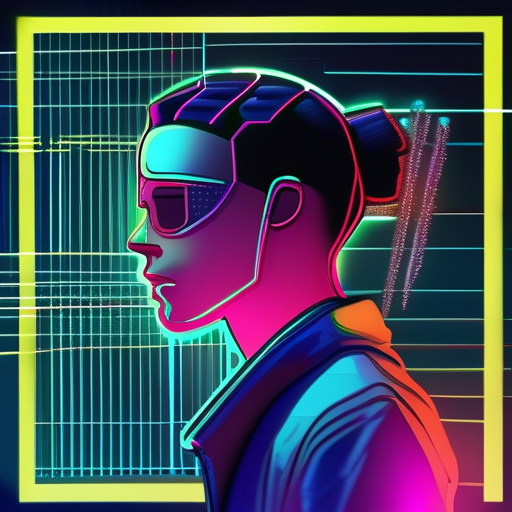

Самопрезентация_neon.jpg: ~45 KB

===  Профессиональное достижение  ===
Стиль: vk_flat


  0%|          | 0/25 [00:00<?, ?it/s]

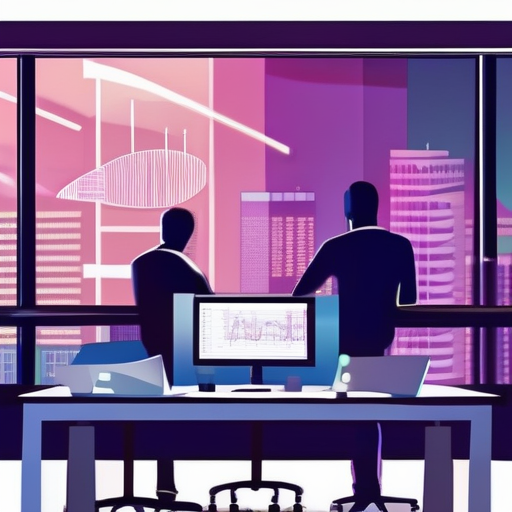

Профессиональное_достижение_vk_flat.jpg: ~33 KB
Стиль: neon


  0%|          | 0/25 [00:00<?, ?it/s]

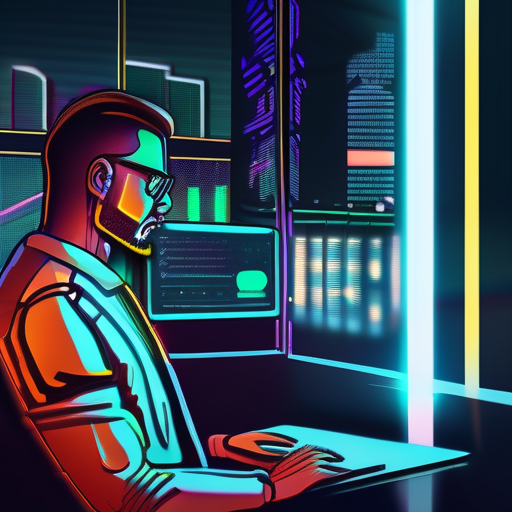

Профессиональное_достижение_neon.jpg: ~43 KB

===  Команда VK  ===
Стиль: vk_flat


  0%|          | 0/25 [00:00<?, ?it/s]

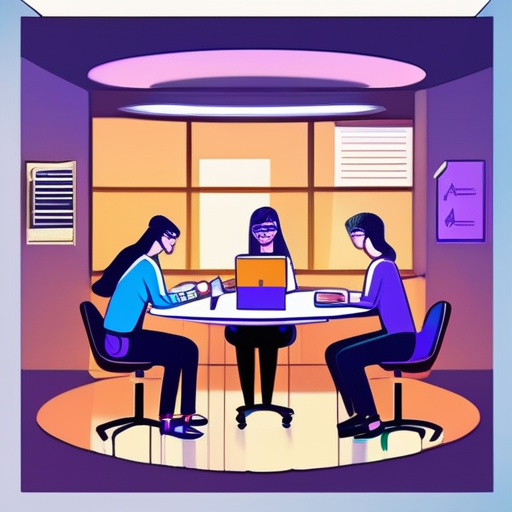

Команда_VK_vk_flat.jpg: ~35 KB
Стиль: neon


  0%|          | 0/25 [00:00<?, ?it/s]

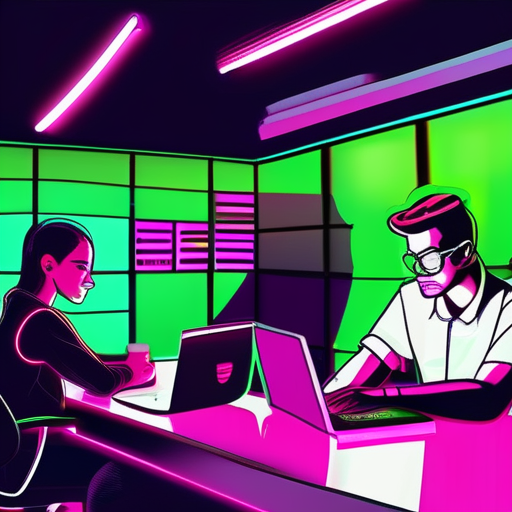

Команда_VK_neon.jpg: ~40 KB


In [9]:
for scene_name, base in base_prompts.items():
    print("\n=== ", scene_name, " ===")
    for style_key in main_styles:
        full_prompt = build_prompt(base, style_key)
        print("Стиль:", style_key)
        img = generate_one(full_prompt, steps=25, guidance=7.5,
                           height=512, width=512)
        display(img)
        filename = f"{scene_name}_{style_key}.jpg".replace(" ", "_")
        save_compressed(img, filename, quality=75)